In [2]:
import os

import torch
import torch.nn as nn
import torchvision
from tqdm import tqdm

import pickle
from matplotlib import pyplot as plt

## 2. FGSM

- 在Task1中，你已经完成了一个LeNet5模型的训练；接下来，请你在少量样本上实现对该模型的FGSM攻击

- 具体实验步骤如下：
  
  1. 将代码文件上传到服务器端根目录，保证你已经完成了Task1且model/目录中存有训练好的模型参数；
  
  2. 在服务器端根目录下新建目录data，并将样本数据（Week567_img_label.pkl）上传至data/目录下；
  
  3. 依照提示，完成Python文件中`fgsm(imgs, epsilon, model, criterion, labels)`函数的两个TODO内容：
     - 根据模型对给定样本的预测结果计算loss，并回传、方便梯度获取 
     - FGSM对抗样本生成过程，实现：$\tilde{x}=x+\epsilon\cdot \text{sign}(\nabla_x \ell(f_\theta(x),y))$
        - 助教测试时要求$\epsilon = 0.2$
        - 最后需要记得将生成的对抗样本clip到图片合法值域范围内（[0, 1]）
  
  4. 执行代码完成攻击与效果验证；
     - **正确实现要求对抗样本的匹配率低于0.4**。

In [3]:
from Week567_General_Code_Question import LeNet5, fgsm, evaluate
from Week567_General_Code_Question import visualize_benign, visualize_adv

### 目标模型加载

In [4]:
model = LeNet5()
model.load_state_dict(torch.load('model/lenet5.pt'))
model.eval()

criterion = nn.CrossEntropyLoss()

### 读入待攻击的样本

再次提醒，在服务器端根目录下新建目录data，并将样本数据（Week567_img_label.pkl）上传至data/目录下

In [5]:
with open('data/Week567_img_label.pkl', 'rb') as f:
    data = pickle.load(f)
    imgs, labels = data['img'], data['label']
    print(imgs.shape, labels.shape)

torch.Size([20, 1, 28, 28]) torch.Size([20])


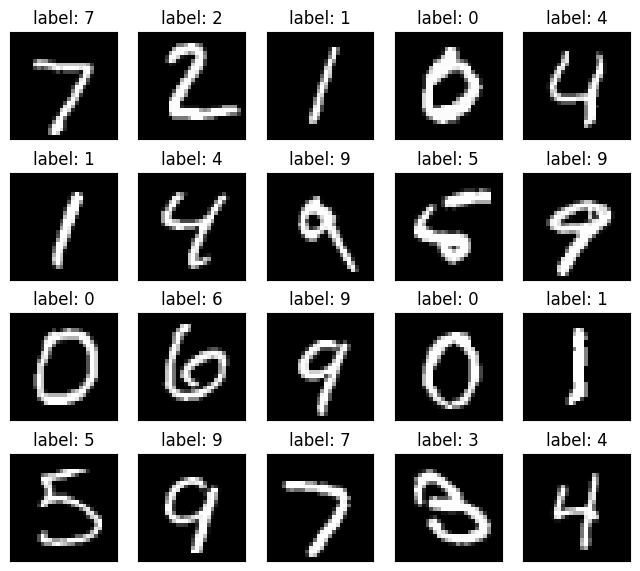

In [6]:
visualize_benign(imgs, labels)

### 实施FGSM生成对抗样本

请你在文件Week567_General_Code_Question.py的`fgsm(imgs, epsilon, model, criterion, labels)`函数中实现两个TODO内容：
- 根据模型对给定样本的预测结果计算loss，并回传、方便梯度获取 
- FGSM对抗样本生成过程，实现：$\tilde{x}=x+\epsilon\cdot \text{sign}(\nabla_x \ell(f_\theta(x),y))$
  - 助教测试时要求$\epsilon = 0.2$
  - 最后需要记得将生成的对抗样本clip到图片合法值域范围内（[0, 1]）

下面是一些供你参考/可能用到的API函数：

- torch.Tensor.requires_grad [Link](https://pytorch.org/docs/stable/generated/torch.Tensor.requires_grad.html)
  - 设置tensor是否加入计算图，即是否需要反向累积梯度
- torch.Tensor.grad [Link](https://pytorch.org/docs/stable/generated/torch.Tensor.grad.html)
  - 在loss.backward()后，获取tensor上的梯度
- torch.Tensor.sign() [Link](https://pytorch.org/docs/stable/generated/torch.Tensor.sign.html)
  - 取一个tensor中每个元素的符号（正负1），返回的形状与输入相同
- torch.clamp(*input*, *min=None*, *max=None*, ***, *out=None*) [Link](https://pytorch.org/docs/stable/generated/torch.clamp.html)
  - input: 需要clip的tensor
  - min, max: 截断的阈值，使tensor中在[min, max]以外的值被截断至min或max
- torch.Tensor.detach() [Link](https://pytorch.org/docs/stable/generated/torch.Tensor.detach.html)
  - 获取一个脱离计算图的tensor，获得的tensor不再会被反向计算梯度


In [7]:
# perform fgsm attack and evaluate
epsilon = 0.2
adv_xs = fgsm(imgs, epsilon, model, criterion, labels)

### 评测对抗样本的攻击效果

请你在文件Week567_General_Code_Question.py的`evaluate(imgs, labels, model)`函数中实现下述TODO内容：

evaluate()函数评估模型对样本adv_xs的预测结果与真实标签labels的匹配率。该匹配率越低，则攻击效果越好。**正确实现要求对抗样本的匹配率低于0.4**。

- torch.argmax(*input*, *dim*, *keepdim=False*) [Link](https://pytorch.org/docs/stable/generated/torch.argmax.html)
  - input: 计算基于的tensor
  - dim: 希望按哪个维度求max下标
- torch.Tensor.item() [Link](https://pytorch.org/docs/stable/generated/torch.Tensor.item.html)
  - 获取单元素tensor的标准python格式值

In [8]:
pred_label = evaluate(adv_xs, labels, model)

match rate: 0.0


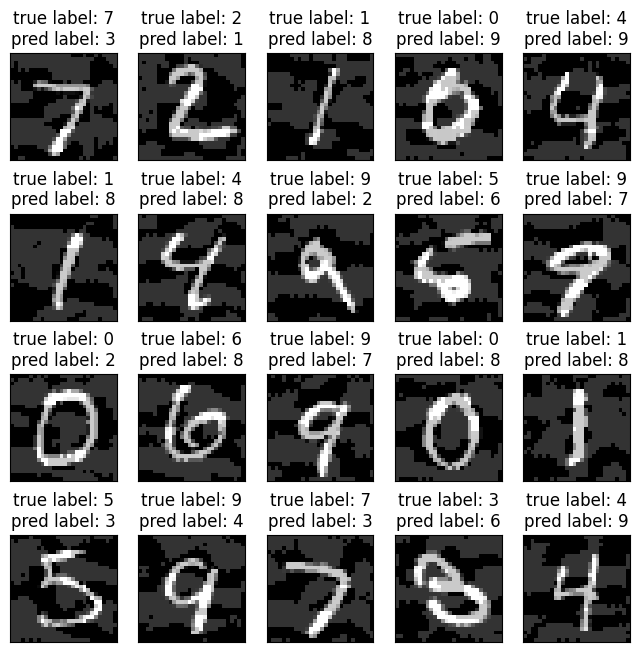

In [9]:
adv_imgs = adv_xs.reshape_as(imgs)
visualize_adv(adv_imgs, labels, pred_label)

In [10]:
with open('data/fgsm_img_label.pkl', 'wb') as f:
    pickle.dump({
        'adv_img': adv_imgs,
        'true_label': labels,
        'pred_label': pred_label,
    }, f)